In [17]:
%matplotlib inline

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

from torchmetrics import functional as FM

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

## MNIST Data Load

In [2]:
mnist_train = MNIST(root='./mnist' , train=True, download=True, transform=transforms.ToTensor())
mnist_test = MNIST(root='./mnist' ,train=False, download=True, transform=transforms.ToTensor())
print ("mnist_train:\n",mnist_train,"\n")
print ("mnist_test:\n",mnist_test,"\n")
print ("Done.")

mnist_train:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist
    Split: Train
    StandardTransform
Transform: ToTensor() 

mnist_test:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./mnist
    Split: Test
    StandardTransform
Transform: ToTensor() 

Done.


## Train/Validation split

In [3]:
train_dataset, val_dataset = random_split(mnist_train, [54000,6000])

## Create Model

In [4]:
class CnnClassifier(LightningModule):
    def __init__(self, lr):
        super(CnnClassifier, self).__init__()
        self. lr = lr

        self.valid_loss = 0
        self.valid_acc = 0
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,32,3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p = 0.5)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32,64,3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p = 0.5)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128,3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p = 0.5)
        )

        self.fc = nn.Sequential(
            nn.Linear(1152, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x ,y = batch
        logits = self(x)
        acc = FM.accuracy(logits ,y)
        loss = F.cross_entropy(logits,y)
        metrics = {
            "val_acc" : acc,
            'val_loss' : loss
        }
        self.log_dict(metrics)
        
    def test_step(self, batch, batch_idx):
        x ,y = batch
        logits = self(x)
        acc = FM.accuracy(logits ,y)
        loss = F.cross_entropy(logits,y)
        metrics = {
            "test_acc" : acc,
            'test_loss' : loss
        }
        self.log_dict(metrics)

    
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr = self.lr)
        return optim

## Parameter define

In [5]:
lr = 1e-3
batch_size = 64
epochs = 10
pl.seed_everything(42)

Global seed set to 42


42

## Data Loader

In [11]:
train_loader = DataLoader(train_dataset, batch_size= batch_size, num_workers = 4)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers = 4)
test_loader = DataLoader(mnist_test, batch_size=batch_size, num_workers = 4)

## Train Model

In [18]:
# callbacks
checkpoint_callback = ModelCheckpoint(
    '{epoch:02d}_{val_acc:.4f}',
    save_top_k= 1,
    monitor='val_acc',
    mode='max'
)

In [22]:
model = CnnClassifier(lr)

trainer = Trainer(max_epochs = epochs, 
                  gpus= 0,
                  checkpoint_callback=checkpoint_callback,)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(model, train_loader, valid_loader)


  | Name   | Type       | Params
--------------------------------------
0 | layer1 | Sequential | 320   
1 | layer2 | Sequential | 18.5 K
2 | layer3 | Sequential | 73.9 K
3 | fc     | Sequential | 595 K 
--------------------------------------
688 K     Trainable params
0         Non-trainable params
688 K     Total params
2.753     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Test Model

In [24]:
trainer.test(model, test_loader)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9921000003814697
        test_loss          0.027315594255924225
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9921000003814697, 'test_loss': 0.027315594255924225}]

## Inference 

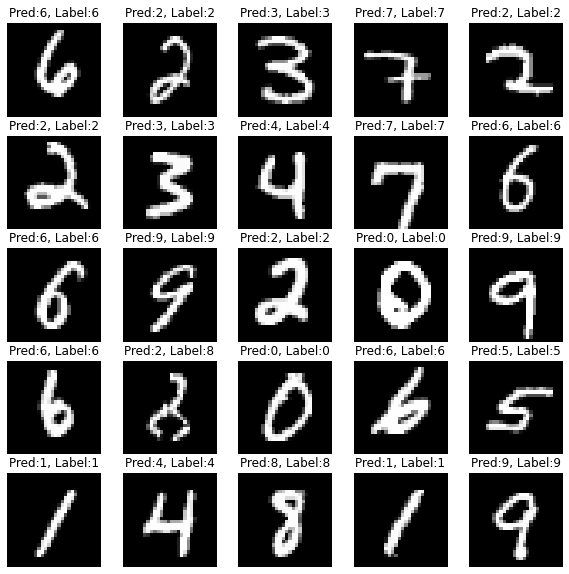

Done


In [25]:
sample_idx = np.random.choice(len(mnist_test.targets),25,replace=False)
test_x = mnist_test.data[sample_idx]
test_y = mnist_test.targets[sample_idx]

model.eval()

y_pred = model(test_x.view(-1,1,28,28).type(torch.float))
y_pred = y_pred.argmax(axis = 1)
plt.figure(figsize=(10,10))
for idx in range(25):
    plt.subplot(5,5,idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))

plt.show()    
print("Done")